# Predykcja cen nieruchomości oparta na modelu maszyny wektorów nośnych

## Wstęp

Dokumentacja będzie skupiała się na rozwiązaniu problemu przewidywania cen nieruchomości z perspektywy potencjalnego kupującego oraz sprzedającego


A house value is simply more than location and square footage. Like the features that make up a person, an educated party would want to know all aspects that give a house its value.

We are going to take advantage of all of the feature variables available to use and use it to analyze and predict house prices.

We are going to break everything into logical steps that allow us to ensure the cleanest, most realistic data for our model to make accurate predictions from.

Load Data and Packages
Analyzing the Test Variable (Sale Price)
Multivariable Analysis
Impute Missing Data and Clean Data
Feature Transformation/Engineering
Modeling and Predictions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
#import xgboost as xgb
#import lightgbm as lgb
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [2]:
# Load train and Test set
train = pd.read_csv("./boston-housing/train.csv")
test = pd.read_csv("./boston-housing/test.csv")

In [3]:
# Check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Save the 'Id' column
train_ID = train['ID']
test_ID = test['ID']

# Now drop the 'Id' column since it's unnecessary for the prediction process.
train.drop("ID", axis = 1, inplace = True)
test.drop("ID", axis = 1, inplace = True)

# Check data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (333, 15) 
The test data size before dropping Id feature is : (173, 14) 

The train data size after dropping Id feature is : (333, 14) 
The test data size after dropping Id feature is : (173, 13) 


In [4]:
train.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9


In [5]:
test.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat
0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
1,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222,18.7,394.12,5.21
2,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311,15.2,396.90,19.15
3,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311,15.2,386.63,29.93
4,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311,15.2,386.71,17.10


In [6]:
# Getting Description
train['medv'].describe()

count    333.000000
mean      22.768769
std        9.173468
min        5.000000
25%       17.400000
50%       21.600000
75%       25.000000
max       50.000000
Name: medv, dtype: float64

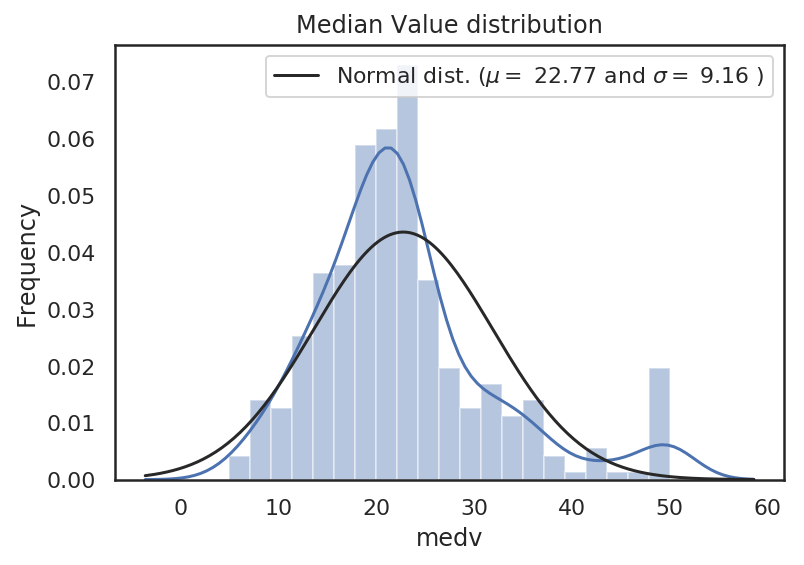

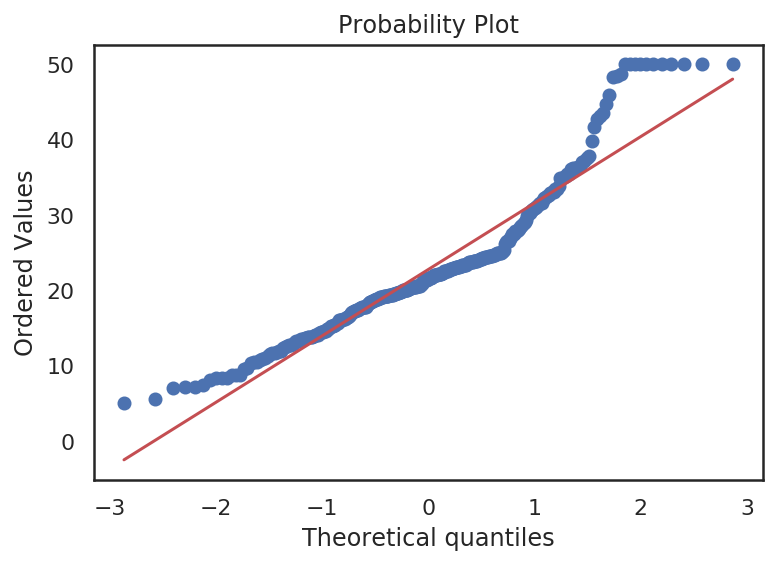

Skewness: 1.122472
Kurtosis: 1.558037


In [10]:
# Plot Histogram
sns.distplot(train['medv'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['medv'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Median Value distribution')

fig = plt.figure()
res = stats.probplot(train['medv'], plot=plt)
plt.show()

print("Skewness: %f" % train['medv'].skew())
print("Kurtosis: %f" % train['medv'].kurt())

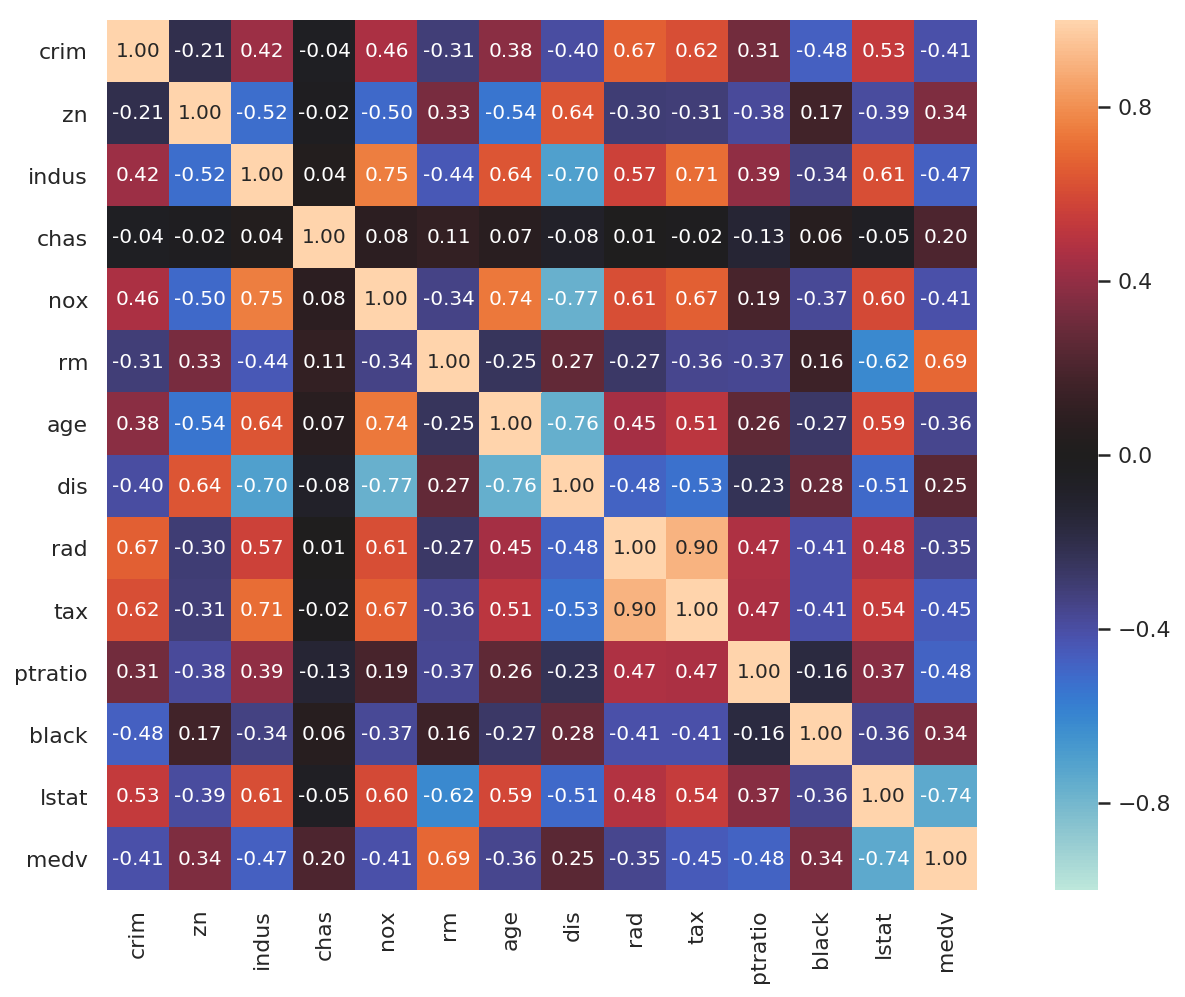

In [31]:
# Correlation Matrix Heatmap
corrmat = train.corr()
f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corrmat, vmin=-1, vmax=1, square=True, center=0, annot=True, fmt='.2f');

In [35]:
cols = corrmat.abs().nlargest(14, 'medv')['medv'].index
most_corr = pd.DataFrame(cols)
most_corr.columns = ['Most Correlated Features']
most_corr

,Most Correlated Features
0,medv
1,lstat
2,rm
3,ptratio
4,indus
5,tax
6,nox
7,crim
8,age
9,rad


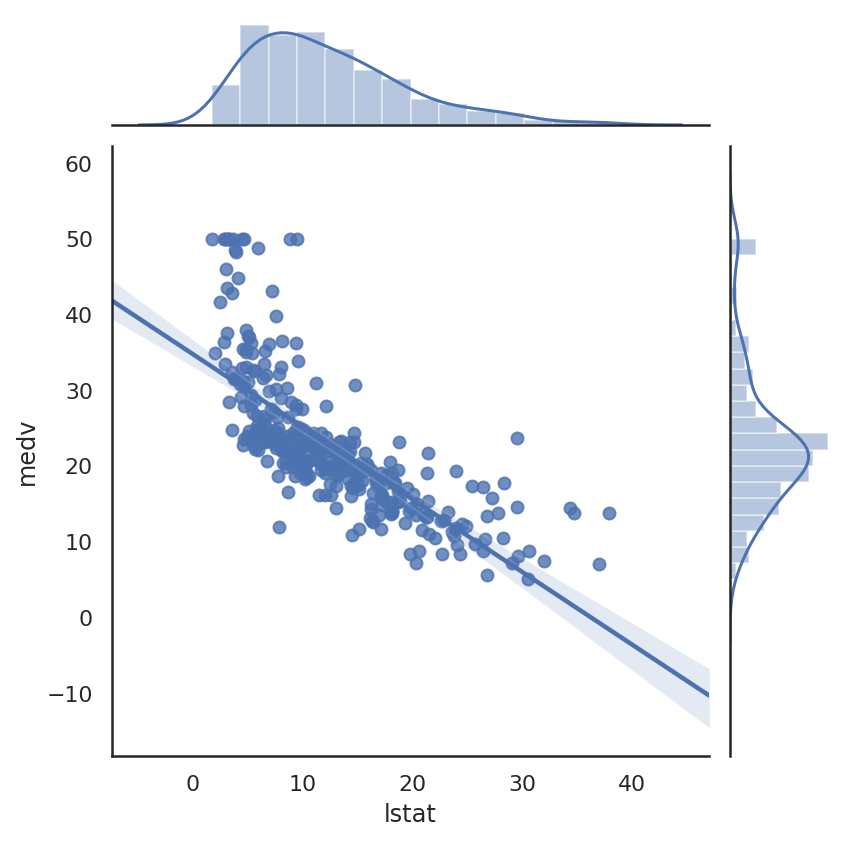

In [46]:
sns.jointplot(x=train['lstat'], y=train['medv'], kind='reg');
#pearsonr(train['lstat'], train['medv']);

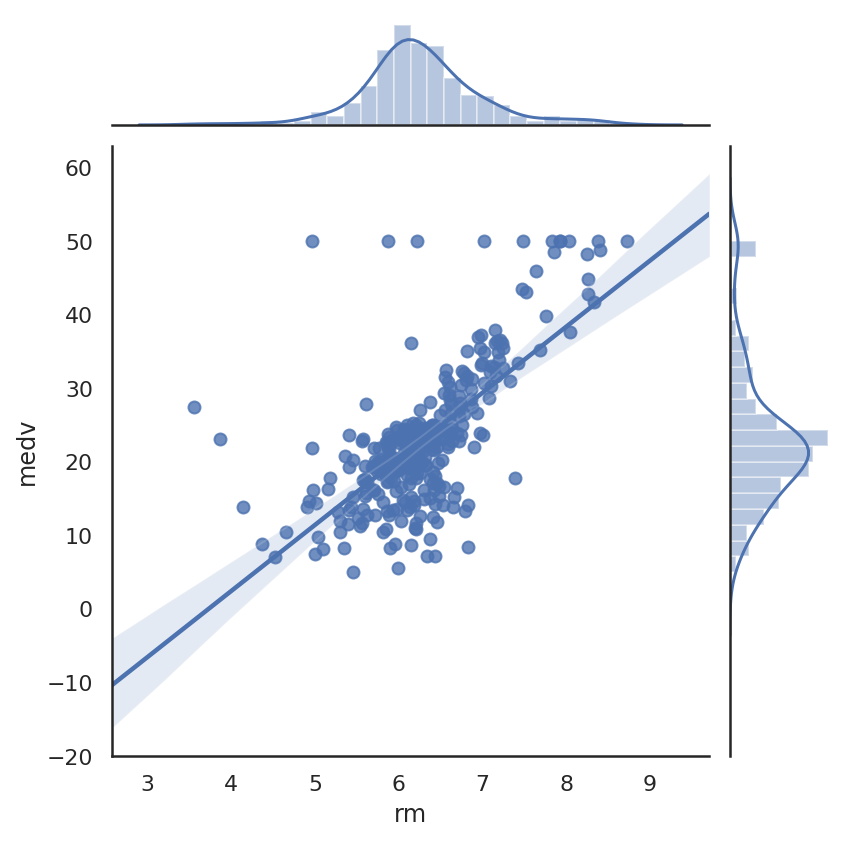

In [39]:
sns.jointplot(x=train['rm'], y=train['medv'], kind='reg');

(-0.48137595552491763, 1.0190852751793372e-20)

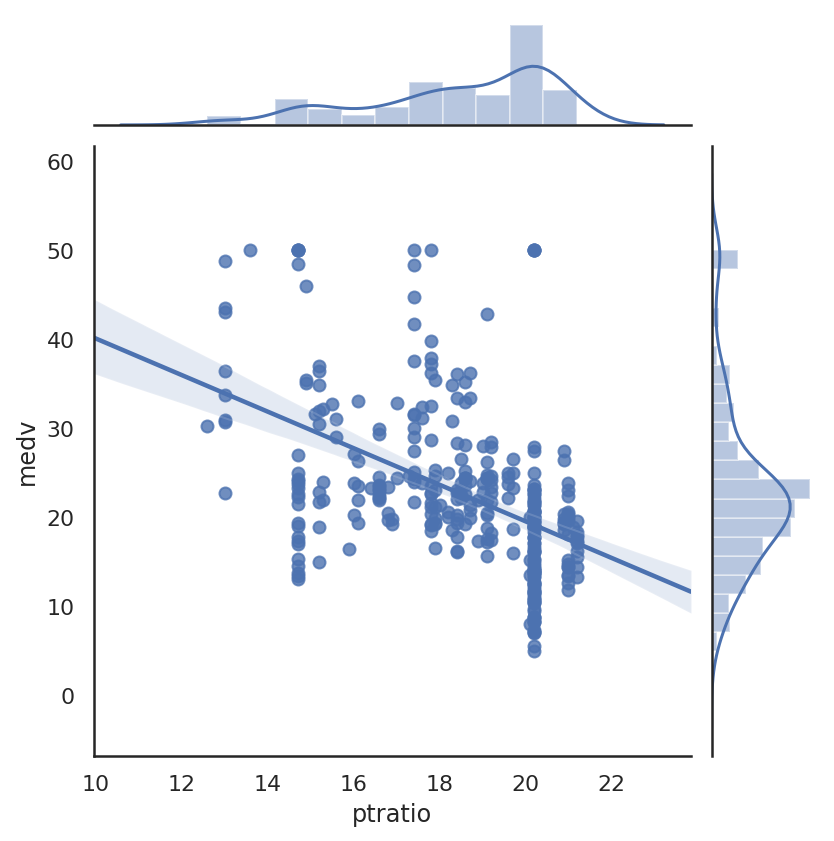

In [48]:
sns.jointplot(x=train['ptratio'], y=train['medv'], kind='reg');
pearsonr(train['ptratio'], train['medv'])

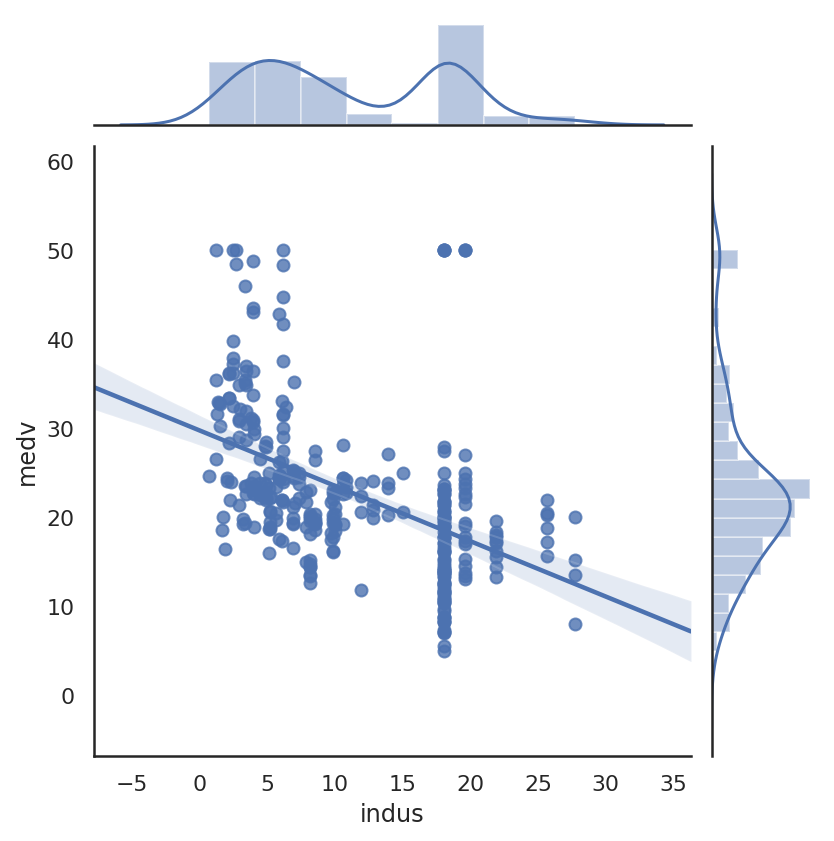

In [49]:
sns.jointplot(x=train['indus'], y=train['medv'], kind='reg');
pearsonr(train['indus'], train['medv']);

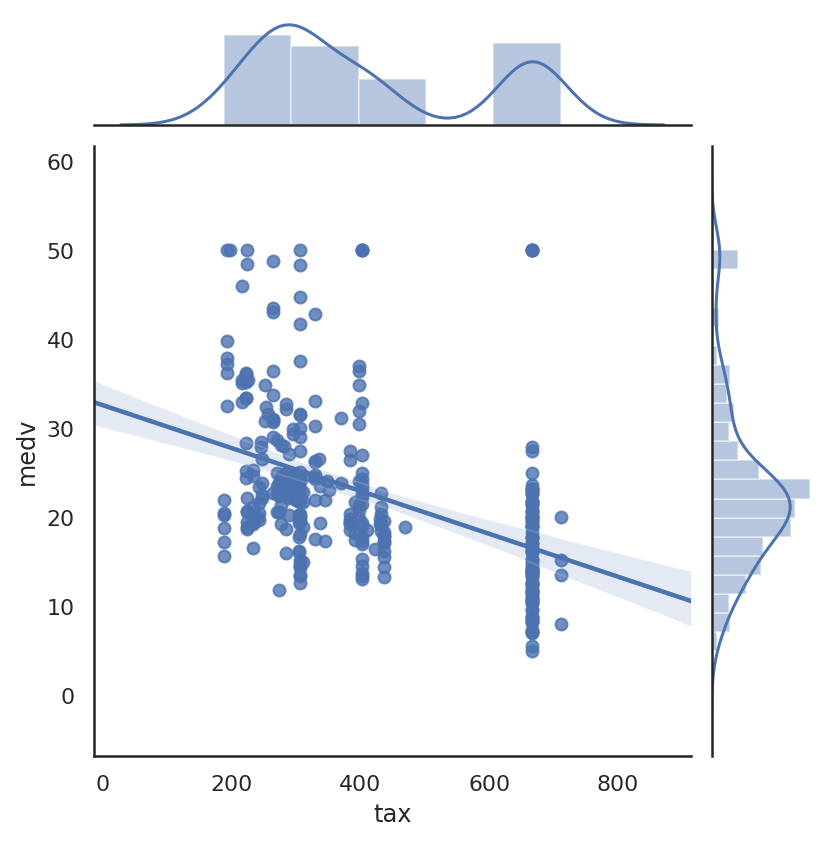

In [50]:
sns.jointplot(x=train['tax'], y=train['medv'], kind='reg');
pearsonr(train['tax'], train['medv']);